![actual brick](./brick_logo.png)

# BRICK: Localized projections

* Make localized projections using results from [Wong and Keller (2017)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2017EF000607)
* Uses local sea level fingerprints of [Slangen et al. (2014)](https://link.springer.com/article/10.1007/s10584-014-1080-9)
* User-defined latitude/longitude for local sea level
* Result is a netCDF file of localized annual mean sea levels
* Include or not include sudden, rapid sea-level contribution from the Antarctic ice sheet (AIS fast dynamics)
* Include any of RCP2.6, 4.5, 6.0 and 8.5

Question?  I'm always happy to chat!  Tony Wong (<anthony.e.wong@colorado.edu>)

---

## Location

Where would you like localized projections?  Enter latitude and longitude as degrees north and degrees east. Here, we demonstrate using the latitude and longitude coordinates of Norfolk, Virginia (USA).

In [1]:
lat <- 37    # degrees North
lon <- -76   # degrees East

## BRICK output file

Which BRICK output file would you like? Defaults to the results from Wong and Keller (2017) using `gamma` prior distributions for the Antarctic ice sheet fast dynamics parameters (as in [Wong et al. (2017)](https://link.springer.com/article/10.1007/s10584-017-2039-4)), but you could change this to other BRICK output files if you would like.  This path is assumed relative to the BRICK home directory.

In [2]:
filename.brick <- paste('output_model/BRICK_physical_fd-gamma_08May2017.nc', sep='')

### Antarctic fast dynamics

If you want projections that do not include the Antarctic ice sheet fast dynamics contributions, the set this to FALSE.

In [3]:
use_fastdynamics <- TRUE

Do a check to see if the requested file is local.  If not, go grab it from download server. Check out the `GrabOutputFiles.R` routine, and the model output in the `output_model` directory for some ideas.

Note that the `list.files` function does not prepend the file name and directory path with `./` or anything like that. Doing so will confuse it. So, just start with the directory/file name.

In [4]:
files <- list.files(recursive=TRUE)
ifile <- which(files==filename.brick)
found <- length(ifile) > 0

# Check if the file is found
if(found) {
    print('Found file! Proceeding with projections.')
} else {
    print(paste('File ',filename.brick,' not found. Check the spelling, or go grab it from the download server...', sep=''))
}

[1] "Found file! Proceeding with projections."


## Read the results file

Edit here the `rcps` variable if you only want a particular subset of the RCP scenarios. And we will initialize lists for the global mean sea level, local sea level, Antarctic ice sheet contribution to sea level, Greenland ice sheet contribution to sea level, glaciers and ice caps contribution to sea level, thermal expansion contribution to sea level, land water storage contribution to sea level, global mean temperature, and ocean heat uptake.

In [5]:
# make sure ncdf4 package is installed; install it, if not
if('ncdf4' %in% rownames(installed.packages()) == FALSE) {install.packages('ncdf4')}
library(ncdf4)

# make projections for all 4 RCP scenarios
rcps <- c('RCP26','RCP45','RCP60','RCP85'); n.rcp <- length(rcps)

# initialize lists for model output
gmsl <- lsl <- ais <- gis <- gsic <- 
            te <- lws <- temp <- ocheat <- vector('list', n.rcp)

# the first level of each list will be for each RCP scenario's projections
# of that quantity
names(gmsl) <- names(lsl) <- names(ais) <- names(gis) <- names(gsic) <- 
            names(te) <- names(lws) <- names(temp) <- names(ocheat) <- rcps

ncdata <- nc_open(filename.brick)

for (rcp in rcps) {
    gmsl[[rcp]]   <- ncvar_get(ncdata, paste('GlobalSeaLevel_',rcp, sep=''))
    ais[[rcp]]    <- ncvar_get(ncdata, paste('AIS_',rcp, sep=''))
    gis[[rcp]]    <- ncvar_get(ncdata, paste('GIS_',rcp, sep=''))
    gsic[[rcp]]   <- ncvar_get(ncdata, paste('GSIC_',rcp, sep=''))
    te[[rcp]]     <- ncvar_get(ncdata, paste('TE_',rcp, sep=''))
    lws[[rcp]]    <- ncvar_get(ncdata, paste('LWS_',rcp, sep=''))
    temp[[rcp]]   <- ncvar_get(ncdata, paste('temp_',rcp, sep=''))
    ocheat[[rcp]] <- ncvar_get(ncdata, paste('ocheat_',rcp, sep=''))
    if(!use_fastdynamics) {
        gmsl_nofd   <- ncvar_get(ncdata, paste('GlobalSeaLevel_nofd_',rcp, sep=''))
        ais[[rcp]]  <- ais[[rcp]] - (gmsl[[rcp]] - gmsl_nofd)
        gmsl[[rcp]] <- gmsl_nofd
    }
}

t.proj     <- ncvar_get(ncdata, 'time_proj')
n.ensemble <- length(ncvar_get(ncdata, 'ens'))

nc_close(ncdata)

## Local fingerprinting

Load the global fingerprinting data set (Slangen et al 2014)

In [6]:
filename.fingerprints = './fingerprints/FINGERPRINTS_SLANGEN_Bakker.nc'

ncdata  <- nc_open(filename.fingerprints)
lat.fp  <- ncvar_get(ncdata, 'lat')
lon.fp  <- ncvar_get(ncdata, 'lon')
fp.gsic <- ncvar_get(ncdata, 'GLAC')
fp.gis  <- ncvar_get(ncdata, 'GIS')
fp.ais  <- ncvar_get(ncdata, 'AIS')
nc_close(ncdata)

### Get local fingerprints

Convert the given latitude and longitude to degrees East/North, and find the fingerprinting data set location closest to the local sea level lat/lon given.

In [7]:
if(lon < 0) {lon <- lon + 360}  # convert longitude to degrees East
ilat <- which( abs(lat.fp-lat)==min(abs(lat.fp-lat)) )
ilon <- which( abs(lon.fp-lon)==min(abs(lon.fp-lon)) )

It is possible there were multiple lats/lons 'closest' to your given point. In this case, take the average of the ones that are actually numbers.

In [8]:
fp.ais.loc <- mean(fp.ais[ilon,ilat],na.rm=TRUE)
fp.gsic.loc <- mean(fp.gsic[ilon,ilat],na.rm=TRUE)
fp.gis.loc <- mean(fp.gis[ilon,ilat],na.rm=TRUE)
fp.te.loc <- 1.0   # TE response is to global mean temperature, so global mean sea level response is same everywhere
fp.lws.loc <- 1.0  # assume LWS changes uniformly (likely not quite true,
                   # but a small contribution anyway)

Check if the nearest spot ended up on land. If it did, take the average everywhere around the location.

In [9]:
if(is.na(fp.ais.loc) | is.na(fp.gsic.loc) | is.na(fp.gis.loc) | is.na(fp.te.loc)) {
    fp.ais.loc <- mean(fp.ais[(ilon-1):(ilon+1),(ilat-1):(ilat+1)], na.rm=TRUE)
    fp.gsic.loc <- mean(fp.gsic[(ilon-1):(ilon+1),(ilat-1):(ilat+1)], na.rm=TRUE)
    fp.gis.loc <- mean(fp.gis[(ilon-1):(ilon+1),(ilat-1):(ilat+1)], na.rm=TRUE)
    fp.te.loc <- 1.0
    fp.lws.loc <- 1.0
}

If there is still something wrong, probably the desired lat/lon location is accidentally not near the coast.

In [10]:
if(is.na(fp.ais.loc) | is.na(fp.gsic.loc) | is.na(fp.gis.loc) | is.na(fp.te.loc)) {
    print('WARNING -- local sea level fingerprints are NaN. Is the lat/lon point possibly over land?')
}

## Calculate local sea level

In [11]:
for (rcp in rcps) {
    lsl[[rcp]] <- mat.or.vec(nr=nrow(gmsl[[rcp]]), nc=ncol(gmsl[[rcp]]))
    for (sow in 1:n.ensemble) {
        lsl[[rcp]][,sow] <- fp.gis.loc  * gis[[rcp]][,sow]  +
                            fp.ais.loc  * ais[[rcp]][,sow]  +
                            fp.gsic.loc * gsic[[rcp]][,sow] +
                            fp.te.loc   * te[[rcp]][,sow]   +
                            fp.lws.loc  * lws[[rcp]][,sow]
    }
}

### Reference period

Check that all sea-level projections and temperatures are relative to 1986-2005 means. Or change this to whatever you want the reference period to be.  Set `reference_period` to the beginning and ending years of whatever reference period you would like!  Must be within the 1850-2100 simulation years.

In [12]:
reference.period <- c(1986, 2005)

ind.norm <- which(t.proj==reference.period[1]):which(t.proj==reference.period[2])

for (rcp in rcps) {
    lsl[[rcp]] <- lsl[[rcp]] - matrix(apply(X=lsl[[rcp]][ind.norm,], MARGIN=2, FUN=mean), 
                                      nrow=length(t.proj), ncol=n.ensemble, byrow=TRUE)
}

## Write output file

Start by giving it a nice name.

In [13]:
filename.output <- './output_model/projections_norfolk.nc'

Now create the actual file:

In [14]:
dim.tproj    <- ncdim_def('time_proj', 'years', as.double(t.proj))
dim.lat      <- ncdim_def('lat', 'deg N', as.double(length(lat)))
dim.lon      <- ncdim_def('lon', 'deg E', as.double(length(lon)))
dim.ensemble <- ncdim_def('ens', 'ensemble member', as.double(1:ncol(lsl[[1]])), unlim=TRUE)

def.lat <- ncvar_def('lat.lsl', 'deg N', list(dim.lat), -999, longname = 'latitude of local sea level point')
def.lon <- ncvar_def('lon.lsl', 'deg E', list(dim.lon), -999, longname = 'longitude of local sea level point')

def.lsl <- vector('list', n.rcp); names(def.lsl) <- rcps
for (rcp in rcps) {
    def.lsl[[rcp]] <- ncvar_def(paste('LocalSeaLevel_',rcp, sep=''), 'meters', 
                                list(dim.tproj, dim.ensemble), -999, longname = paste('Local sea level ',rcp, sep=''))
}

outlist = list()
for (i in 1:n.rcp) {
    outlist[[i]] <- def.lsl[[i]]
}
outlist[[i+1]] <- def.lat
outlist[[i+2]] <- def.lon

outnc <- nc_create(filename.output, outlist, force_v4=TRUE)

ncvar_put(outnc, def.lat, lat)
ncvar_put(outnc, def.lon, lon)
for (rcp in rcps) {
    ncvar_put(outnc, def.lsl[[rcp]], lsl[[rcp]])
}

nc_close(outnc)

## Sample plots

Below are a couple of sample plots using the BRICK projections from Wong and Keller (2017) for analyses. Feel free to use the codes and model output as you would like, with the usual GPL license caveats, and please remember to cite any relevant works.

### Probability distribution estimates

Here is an example plot of the estimated probability distributions of global mean sea level in 2100, relative to 1986-2005 global mean sea level, for each of the four RCP scenarios.

In [15]:
# first, fit kernel density estimates to each of the projections
kde26 <- density(lsl$RCP26[251,])
kde45 <- density(lsl$RCP45[251,])
kde60 <- density(lsl$RCP60[251,])
kde85 <- density(lsl$RCP85[251,])

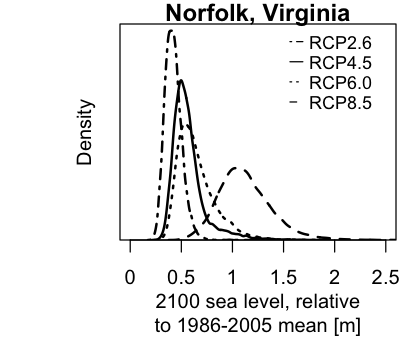

In [16]:
# now, a figure!
options(repr.plot.width=3.5, repr.plot.height=3)
par(mfrow=c(1,1), mai=c(1,1,.2,.2))
plot(kde85$x, kde85$y, type='l', lwd=2, lty=2, xlim=c(0,2.5), ylim=c(0,5.1),
     xaxt='n', yaxt='n', ylab='', yaxs='i', main='Norfolk, Virginia',
     xlab='2100 sea level, relative\nto 1986-2005 mean [m]')
lines(kde60$x, kde60$y, lty=3, lwd=2)
lines(kde45$x, kde45$y, lty=1, lwd=2)
lines(kde26$x, kde26$y, lty=4, lwd=2)
axis(1,seq(0,2.5,.5),lab=c("0","0.5","1","1.5","2","2.5"))
mtext('Density', side=2, line=1, cex=1)
legend(1.5,5,c("RCP2.6","RCP4.5","RCP6.0","RCP8.5"),
       lty=c(4,1,3,2), lwd=1, cex=0.9, bty='n', y.intersp=3)

### Probabilistic projections

Here is an example plot of the sea level and temperature trajectories under the RCP8.5 scenario.

In [17]:
# first, get the ensemble median and 5-95% range for each year for the projections

# indices for the projections from 2000 to 2100
idx <- which(t.proj >= 2000)

# initialize
lsl.q <- mat.or.vec(length(idx), 3)
temp.q <- mat.or.vec(length(idx), 3)

# calculate quantiles over the projections period
for (iy in 1:length(idx)) {
    lsl.q[iy,1] <- quantile(lsl$RCP85[idx[iy],], 0.05)
    lsl.q[iy,2] <- quantile(lsl$RCP85[idx[iy],], 0.50)
    lsl.q[iy,3] <- quantile(lsl$RCP85[idx[iy],], 0.95)
    temp.q[iy,1] <- quantile(temp$RCP85[idx[iy],], 0.05)
    temp.q[iy,2] <- quantile(temp$RCP85[idx[iy],], 0.50)
    temp.q[iy,3] <- quantile(temp$RCP85[idx[iy],], 0.95)
}

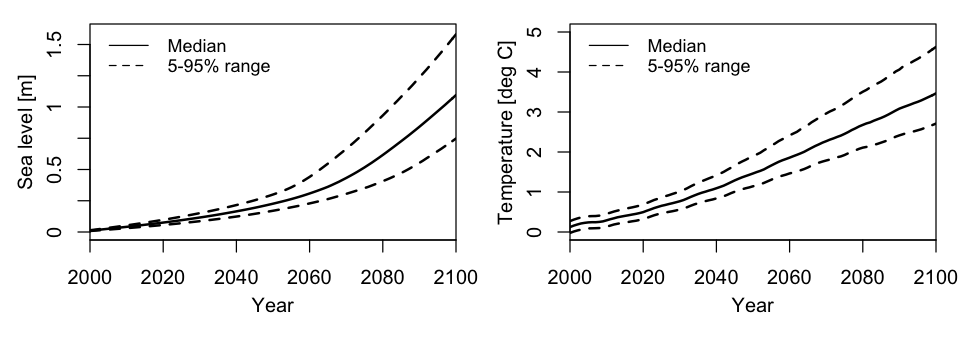

In [18]:
# now... a figure!
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow=c(1,2), mai=c(1,.75,.2,.2))
plot(t.proj[idx], lsl.q[,2], type='l', lwd=2, xlab='', ylab='', main='',
     ylim=c(0,1.6), xaxt='n', yaxt='n', xaxs='i')
lines(t.proj[idx], lsl.q[,1], lwd=2, lty=2)
lines(t.proj[idx], lsl.q[,3], lwd=2, lty=2)
axis(1,seq(2000,2100,20))
axis(2,seq(0,1.5,0.25),c('0','','0.5','','1','','1.5'))
mtext('Year', side=1, line=2.2, cex=1)
mtext('Sea level [m]', side=2, line=2.2, cex=1)
legend(2000,1.6,c("Median","5-95% range"),
       lty=c(1,2), lwd=1, cex=0.9, bty='n', y.intersp=3)

plot(t.proj[idx], temp.q[,2], type='l', lwd=2, xlab='', ylab='', main='',
     ylim=c(0, 5), xaxt='n', yaxt='n', xaxs='i')
lines(t.proj[idx], temp.q[,1], lwd=2, lty=2)
lines(t.proj[idx], temp.q[,3], lwd=2, lty=2)
axis(1,seq(2000,2100,20))
axis(2,seq(0,5,1))
mtext('Year', side=1, line=2.2, cex=1)
mtext('Temperature [deg C]', side=2, line=2.2, cex=1)
legend(2000,5,c("Median","5-95% range"),
       lty=c(1,2), lwd=1, cex=0.9, bty='n', y.intersp=3)